Arxiv has more than 1.5m articles in many fields of study. It was founded by Paul Ginsparg in 1991 and maintained and operated by Cornell University.

In this kernel I work with metadata information from this dataset: https://www.kaggle.com/Cornell-University/arxiv

It contains metadata of papers and information about citations.

Let's see what interesting insights can be extracted form this data!

*Work is still in progress*

![](https://storage.googleapis.com/kaggle-public-downloads/arXiv.JPG)

In [48]:
# import libraries

import numpy as np
import pandas as pd
import gc
import os
import json
from collections import Counter, defaultdict
from tqdm.notebook import tqdm
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import plotly.graph_objs as go

%matplotlib inline
import plotly.express as px
import re
year_pattern = r'([1-2][0-9]{3})'

In [8]:
"""
Json files in the dataset are huge. Sadly, python has certain memory problems when loading huge json files.
As a result, I read this file using `yield` and get necessary information from in in the loop.
"""

def get_metadata():
    with open('arxiv_data/arxiv-metadata-oai-snapshot.json', 'r') as f:
        for line in f:
            yield line

In [262]:
# https://arxiv.org/help/api/user-manual
category_map = {
'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

## Analyze Arxiv

FIRST
Simplify all the code. Make it so that I only have to read things in once, and then I can analyze however I want over time. 
Don't use the L2 norm but instead the L1 norm so that I can directly sum things. 

To do
1. Combine categories, into larger groups, to see evolution between major fields.
2. Also have option to only look within a certain field. 
2. Simplify all the code. 

Maybe get it to work with individual movements rather than averages at a given time? 
I want to know what people move between, not just the average movements are in or out. 

### Basic utils

In [251]:
# Basic utils for dates and stuff


def days_since_2007_to_year_with_fraction(days_since_2007):
    # Define the start date (2007, Jan 1st)
    start_date = datetime(2007, 1, 1)

    # Calculate the end date based on the number of days since the start date
    end_date = start_date + timedelta(days=days_since_2007)

    # Extract the year and day of the year from the end date
    year = end_date.year
    day_of_year = (end_date - datetime(year, 1, 1)).days + 1

    # Calculate the decimal fraction for the partway through the year
    decimal_fraction = day_of_year / 365  # approximate

    # Return the year including the decimal fraction
    return year + decimal_fraction

def extract_days_from_2007_to_pub(paper_versions):
    v1_date_str = None

    for version_info in paper_versions:
        if version_info['version'] == 'v1':
            v1_date_str = version_info['created']
            break

    if v1_date_str is None:
        return None

    v1_date = datetime.strptime(v1_date_str, '%a, %d %b %Y %H:%M:%S %Z')
    days_since_2007 = (v1_date - datetime(2007, 1, 1)).days

    return days_since_2007

### Extract data by publication

In [250]:
# Create a pandas dataframe with each publication information 

MAX_EXTRACTION_LENGTH = 20_000_000  # How many publications to load to save time 
MAX_PUBLICATIONS = 50 # max publications allowed to consider an author (otherwise it's likely a non-unique name)
MIN_PUBLICATIONS = 2
DAYS_DECIMATOR = 150  # how large bins to group together on derivative calculation
DERIVATIVE_EMBEDDING_THRESHOLD = 0.5  # How large change in embedding vector norm must be to register a change. 

# Create an empty list to accumulate rows
rows = []

length = 0
metadata = get_metadata()
for paper in metadata:
    if length > MAX_EXTRACTION_LENGTH:
        break
    paper_data = json.loads(paper)
    
    # Extract and process the data
    paper_id = paper_data['id']
    categories = paper_data['categories'].split()
    pub_date = extract_days_from_2007_to_pub(paper_data['versions'])
    authors_parsed = paper_data['authors_parsed']
    
    # Create a dictionary with the extracted data
    row = {'id': paper_id, 'categories': categories, 'pub_date': pub_date, 'authors_parsed': authors_parsed}

    # Append the row to the rows list
    rows.append(row)
    
    if length % 100_000 == 0:
        print(length, 'done')
    length += 1

# Create a DataFrame using the accumulated rows
columns = ['id', 'categories', 'pub_date', 'authors_parsed']
df = pd.DataFrame(rows, columns=columns)

print(df)

0 done
100000 done
200000 done
300000 done
400000 done
500000 done
600000 done
700000 done
800000 done
900000 done
1000000 done
1100000 done
1200000 done
1300000 done
1400000 done
1500000 done
1600000 done
1700000 done
1800000 done
1900000 done
2000000 done
2100000 done
2200000 done
                       id                     categories  pub_date  \
0               0704.0001                       [hep-ph]        91   
1               0704.0002               [math.CO, cs.CG]        89   
2               0704.0003               [physics.gen-ph]        90   
3               0704.0004                      [math.CO]        89   
4               0704.0005             [math.CA, math.FA]        91   
...                   ...                            ...       ...   
2219418  supr-con/9608008  [supr-con, cond-mat.supr-con]     -3780   
2219419  supr-con/9609001  [supr-con, cond-mat.supr-con]     -3775   
2219420  supr-con/9609002  [supr-con, cond-mat.supr-con]     -3772   
2219421  supr-co

In [324]:

# Get a list of all unique categories
unique_categories = sorted(set(cat for categories in df['categories'] for cat in categories))

# Function to map categories to a unit vector embedding
def category_to_vector(categories):
    vec = np.zeros(len(unique_categories))
    indices = [unique_categories.index(cat) for cat in categories]
    vec[indices] = 1 / np.sqrt(len(categories))
    return vec

def index_to_category(ind):
    return unique_categories[ind]

def index_to_verbose_category(ind):
    cat = index_to_category(ind)
    if cat in category_map:
        return category_map[cat]
    else:
        return cat
    
category_names_verbose = [index_to_verbose_category(which_cat) for which_cat in range(len(unique_categories))]
category_names = [index_to_category(which_cat) for which_cat in range(len(unique_categories))]

In [328]:
detected_categories = set(unique_categories)
listed_categories = set(category_map.keys())
print(detected_categories.difference(listed_categories))
print(listed_categories.difference(detected_categories))

{'bayes-an', 'acc-phys', 'q-alg', 'alg-geom', 'patt-sol', 'funct-an', 'dg-ga', 'adap-org', 'eess.SY', 'q-bio', 'comp-gas', 'chem-ph', 'atom-ph', 'chao-dyn', 'cmp-lg', 'plasm-ph', 'ao-sci', 'mtrl-th', 'cond-mat', 'solv-int', 'econ.GN', 'supr-con', 'econ.TH'}
set()


### Extract data by author

In [252]:
# Create a dictionary with the contributions of each unique author name. 

# Initialize an empty dictionary to store the authors and their papers
author_papers = {}

# Iterate through the rows of the DataFrame
for index, row in df.iterrows():
    
    paper_id = row['id']
    categories = row['categories']
    pub_date = row['pub_date']
    authors_parsed = row['authors_parsed']

    # Iterate through the authors of each paper
    for author in authors_parsed:
        author_key = "".join(author)  # Create a unique author key

        # If the author is not in the dictionary, add them with their first paper
        if author_key not in author_papers:
            author_papers[author_key] = []

        # Add the paper information to the author's list of papers
        author_papers[author_key].append([paper_id, pub_date, categories])

print(len(author_papers))


1768814


### Extract derivative data by date 

In [253]:
# Process data for each author, getting their derivatives over time. 

def compute_time_series_derivative(time_series):
    """
    This function, compute_time_series_derivative, takes a sorted time_series object as 
    input and returns a new time_series_derivative object with the same format. 
    It iterates through the time_series, calculates the average of all previous 
    category_embedding objects, computes the difference between the current 
    category_embedding and the average, and stores the difference along with the 
    pub_date in the time_series_derivative object.

    """
    time_series_derivative = []
    running_sum = np.zeros(len(unique_categories))
    num_previous = 0

    for pub_date, current_embedding in time_series:
        if num_previous > 0:
            previous_average = running_sum / num_previous
            difference = current_embedding - previous_average
            time_series_derivative.append((pub_date, difference))
        else:
            time_series_derivative.append((pub_date, np.zeros(len(unique_categories))))

        running_sum += current_embedding
        num_previous += 1

    return time_series_derivative


# Initialize a new dictionary to store the author metadata
author_metadata = {}
date_count = defaultdict(lambda: 0)
date_derivative_accumulator = defaultdict(lambda: np.zeros(len(unique_categories)))

# Iterate through each author and their papers
num_authors = 0
for author_key, papers in author_papers.items():
    if len(papers) > MAX_PUBLICATIONS or len(papers) < MIN_PUBLICATIONS:
        continue  # skip them 
        
    time_series = []

    # Iterate through each paper by the author
    for paper in papers:
        paper_id, pub_date, categories = paper
        category_embedding = category_to_vector(categories)
        time_series.append((pub_date, category_embedding))

    # Sort the time series by pub_date
    time_series = sorted(time_series, key=lambda x: x[0])
    
    # Get derivative of publication category over time 
    time_series_derivative = compute_time_series_derivative(time_series)
    
    # Store the author metadata in the new dictionary
    author_metadata[author_key] = {
        'time_series': time_series,
        'time_series_derivative': time_series_derivative
    }
    
    # Store the data from each time_series derivative 
    for days_raw, emb in time_series_derivative:
        emb_norm = np.linalg.norm(emb)
        if emb_norm > DERIVATIVE_EMBEDDING_THRESHOLD:
            days = int((days_raw // DAYS_DECIMATOR) * DAYS_DECIMATOR)
            date_count[days] += 1
            date_derivative_accumulator[days] += emb
    
    num_authors += 1

date_derivative = {days : date_derivative_accumulator[days]/date_count[days] for days in date_count.keys()}

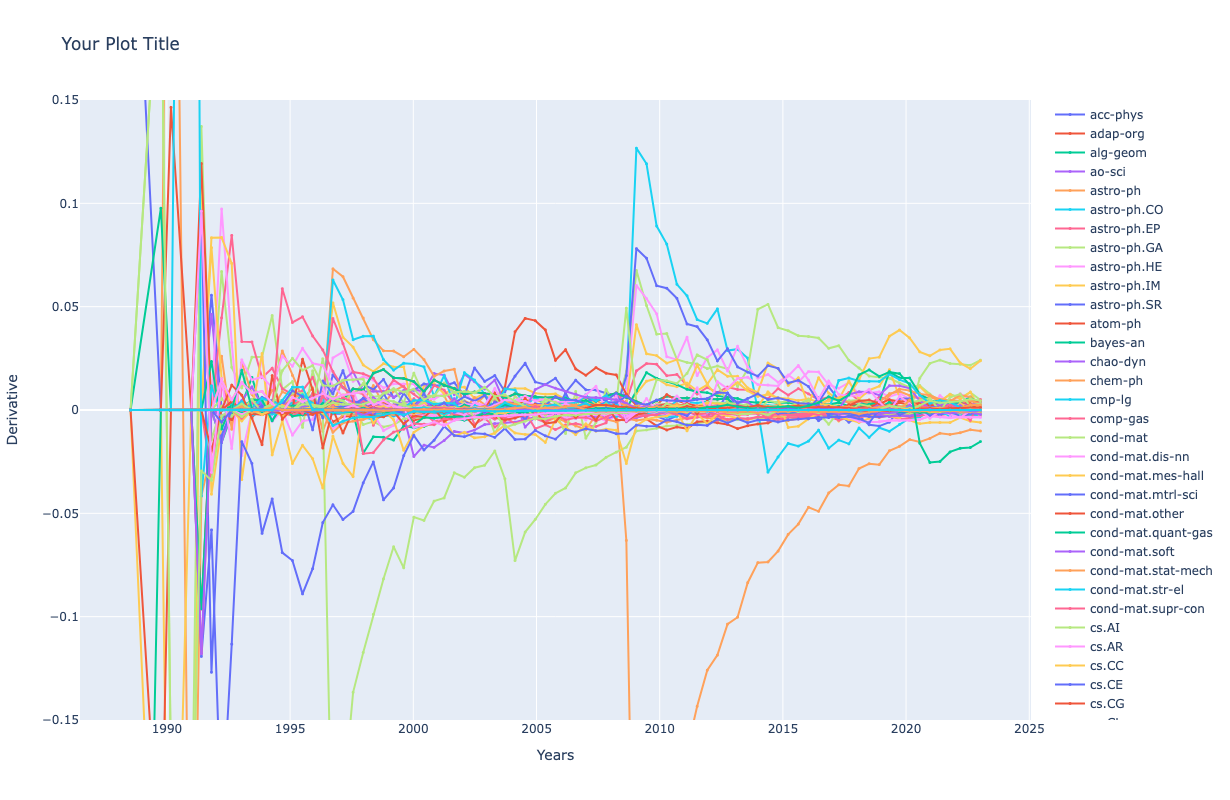

In [333]:
target_str = ''
plt_range = 0.15


fig = go.Figure()

# Plot the data and add labels to the lines
for which_cat, category_name in enumerate(category_names):
    if target_str in index_to_category(which_cat):

        deriv_x = [date_derivative[day][which_cat] for day in days]
        #fig.add_trace(go.Scatter(x=years, y=deriv_x, mode='lines+markers', marker=dict(size=3), name=category_name))
        fig.add_trace(go.Scatter(
            x=years,
            y=deriv_x,
            mode='lines+markers',
            marker=dict(size=3),
            name=category_name,
            hovertemplate='%{y:.2f}',
            # line=dict(color='gray', width=1),
            hoverinfo='name+y',
        ))
    
# Customize the layout
fig.update_layout(
    title="Your Plot Title",
    xaxis_title="Years",
    yaxis_title="Derivative",
    hovermode="closest",
    width=1200,
    height=800,
    yaxis_range=[-plt_range, plt_range]
)

# # # Update the line opacity on hover
# fig.update_traces(hoveron='points+fills', hoverlabel=dict(bgcolor='white'))

fig.show()

(0.0, 50.0)

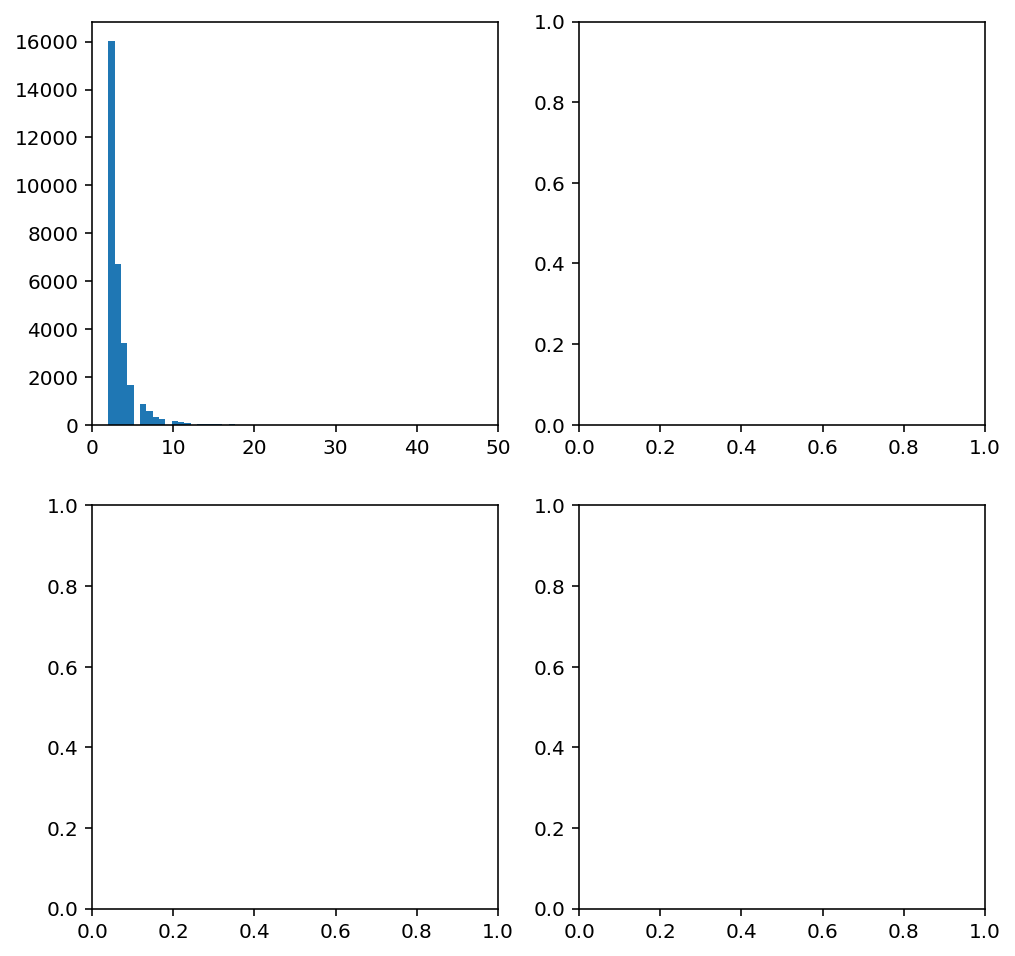

In [205]:
# plt.hist(avg_pub_dates, bins=100)
fig, ax = plt.subplots(2,2, figsize=(8,8))

ax[0][0].hist(num_papers, bins=50)
ax[0][0].set_xlim([0,50])

# ax[0][1].plot(avg_pub_dates, num_papers,  ls='', marker='.', ms=0.5)

# ax[1][1].plot(np.array(avg_pub_dates)/365.0, deriv_mag, ls='', marker='.', ms=0.5)


(0.0, 200.0)

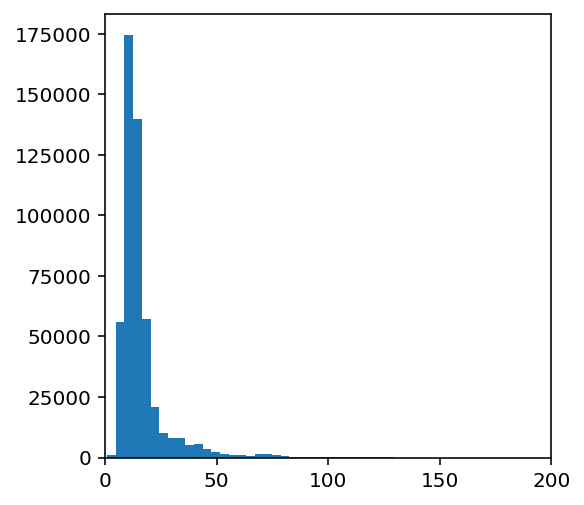

In [148]:
num_papers = [len(paps) for paps in author_papers.keys()]

fig, ax = plt.subplots(figsize=(4,4))
ax.hist(num_papers, bins=100)
ax.set_xlim([0,200])
# ax.set_yscale("log")

In [46]:
length = 0
metadata = get_metadata()
for paper in metadata:
    paper_data = json.loads(paper)
    # paper_data is dictionary 
    
    print(paper_data['id'])
    print(paper_data['categories'])
    print(paper_data['update_date'])
    print(paper_data['authors_parsed'])
    length += 1
    if length == 1:
        break

0704.0001
hep-ph
2008-11-26
[['Balázs', 'C.', ''], ['Berger', 'E. L.', ''], ['Nadolsky', 'P. M.', ''], ['Yuan', 'C. -P.', '']]


In [34]:
length = 0
metadata = get_metadata()
for paper in metadata:
    pap = json.loads(paper)
    if length % 100000 == 0:
        print(length, pap['title'])
    length += 1
print(length)

0 Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
100000 Vacuum Stability with Tachyonic Boundary Higgs Masses in No-Scale
  Supersymmetry or Gaugino Mediation
200000 Adhesive Penetration in Beech Wood Part I: Experiments
300000 A Well-Posed Kelvin-Helmholtz Instability Test and Comparison
400000 Fractures in complex fluids: the case of transient networks
500000 Islands in graphs on surfaces
600000 Sieved Enumeration of Interval Orders and Other Fishburn Structures
700000 Receding Horizon Consensus of General Linear Multi-agent Systems with
  Input Constraints: An Inverse Optimality Approach
800000 DEMoS Manifesto
900000 Planetary formation and water delivery in the habitable zone around
  solar-type stars in different dynamical environments
1000000 Stable Branched Electron Flow
1100000 HexaShrink, an exact scalable framework for hexahedral meshes with
  attributes and discontinuities: multiresolution rendering and storage of
  geoscience models


# What data do I want. 
I want to extract the author unique ID, and for each I want to record all papers published.

So while looping through, add unique author id to dictionary if it is not already there, then add list of publications for each author with id, field tages, and date. 

I don't think I'll use all the information, which is available, but there are several interesting fields:
* the authors of the paper
* the title and the abstract
* categories (in the cell below I made a dictionary to help understand abbreviations)
* jornal-ref - this field should contain year.

In [10]:
# https://arxiv.org/help/api/user-manual
category_map = {'astro-ph': 'Astrophysics',
'astro-ph.CO': 'Cosmology and Nongalactic Astrophysics',
'astro-ph.EP': 'Earth and Planetary Astrophysics',
'astro-ph.GA': 'Astrophysics of Galaxies',
'astro-ph.HE': 'High Energy Astrophysical Phenomena',
'astro-ph.IM': 'Instrumentation and Methods for Astrophysics',
'astro-ph.SR': 'Solar and Stellar Astrophysics',
'cond-mat.dis-nn': 'Disordered Systems and Neural Networks',
'cond-mat.mes-hall': 'Mesoscale and Nanoscale Physics',
'cond-mat.mtrl-sci': 'Materials Science',
'cond-mat.other': 'Other Condensed Matter',
'cond-mat.quant-gas': 'Quantum Gases',
'cond-mat.soft': 'Soft Condensed Matter',
'cond-mat.stat-mech': 'Statistical Mechanics',
'cond-mat.str-el': 'Strongly Correlated Electrons',
'cond-mat.supr-con': 'Superconductivity',
'cs.AI': 'Artificial Intelligence',
'cs.AR': 'Hardware Architecture',
'cs.CC': 'Computational Complexity',
'cs.CE': 'Computational Engineering, Finance, and Science',
'cs.CG': 'Computational Geometry',
'cs.CL': 'Computation and Language',
'cs.CR': 'Cryptography and Security',
'cs.CV': 'Computer Vision and Pattern Recognition',
'cs.CY': 'Computers and Society',
'cs.DB': 'Databases',
'cs.DC': 'Distributed, Parallel, and Cluster Computing',
'cs.DL': 'Digital Libraries',
'cs.DM': 'Discrete Mathematics',
'cs.DS': 'Data Structures and Algorithms',
'cs.ET': 'Emerging Technologies',
'cs.FL': 'Formal Languages and Automata Theory',
'cs.GL': 'General Literature',
'cs.GR': 'Graphics',
'cs.GT': 'Computer Science and Game Theory',
'cs.HC': 'Human-Computer Interaction',
'cs.IR': 'Information Retrieval',
'cs.IT': 'Information Theory',
'cs.LG': 'Machine Learning',
'cs.LO': 'Logic in Computer Science',
'cs.MA': 'Multiagent Systems',
'cs.MM': 'Multimedia',
'cs.MS': 'Mathematical Software',
'cs.NA': 'Numerical Analysis',
'cs.NE': 'Neural and Evolutionary Computing',
'cs.NI': 'Networking and Internet Architecture',
'cs.OH': 'Other Computer Science',
'cs.OS': 'Operating Systems',
'cs.PF': 'Performance',
'cs.PL': 'Programming Languages',
'cs.RO': 'Robotics',
'cs.SC': 'Symbolic Computation',
'cs.SD': 'Sound',
'cs.SE': 'Software Engineering',
'cs.SI': 'Social and Information Networks',
'cs.SY': 'Systems and Control',
'econ.EM': 'Econometrics',
'eess.AS': 'Audio and Speech Processing',
'eess.IV': 'Image and Video Processing',
'eess.SP': 'Signal Processing',
'gr-qc': 'General Relativity and Quantum Cosmology',
'hep-ex': 'High Energy Physics - Experiment',
'hep-lat': 'High Energy Physics - Lattice',
'hep-ph': 'High Energy Physics - Phenomenology',
'hep-th': 'High Energy Physics - Theory',
'math.AC': 'Commutative Algebra',
'math.AG': 'Algebraic Geometry',
'math.AP': 'Analysis of PDEs',
'math.AT': 'Algebraic Topology',
'math.CA': 'Classical Analysis and ODEs',
'math.CO': 'Combinatorics',
'math.CT': 'Category Theory',
'math.CV': 'Complex Variables',
'math.DG': 'Differential Geometry',
'math.DS': 'Dynamical Systems',
'math.FA': 'Functional Analysis',
'math.GM': 'General Mathematics',
'math.GN': 'General Topology',
'math.GR': 'Group Theory',
'math.GT': 'Geometric Topology',
'math.HO': 'History and Overview',
'math.IT': 'Information Theory',
'math.KT': 'K-Theory and Homology',
'math.LO': 'Logic',
'math.MG': 'Metric Geometry',
'math.MP': 'Mathematical Physics',
'math.NA': 'Numerical Analysis',
'math.NT': 'Number Theory',
'math.OA': 'Operator Algebras',
'math.OC': 'Optimization and Control',
'math.PR': 'Probability',
'math.QA': 'Quantum Algebra',
'math.RA': 'Rings and Algebras',
'math.RT': 'Representation Theory',
'math.SG': 'Symplectic Geometry',
'math.SP': 'Spectral Theory',
'math.ST': 'Statistics Theory',
'math-ph': 'Mathematical Physics',
'nlin.AO': 'Adaptation and Self-Organizing Systems',
'nlin.CD': 'Chaotic Dynamics',
'nlin.CG': 'Cellular Automata and Lattice Gases',
'nlin.PS': 'Pattern Formation and Solitons',
'nlin.SI': 'Exactly Solvable and Integrable Systems',
'nucl-ex': 'Nuclear Experiment',
'nucl-th': 'Nuclear Theory',
'physics.acc-ph': 'Accelerator Physics',
'physics.ao-ph': 'Atmospheric and Oceanic Physics',
'physics.app-ph': 'Applied Physics',
'physics.atm-clus': 'Atomic and Molecular Clusters',
'physics.atom-ph': 'Atomic Physics',
'physics.bio-ph': 'Biological Physics',
'physics.chem-ph': 'Chemical Physics',
'physics.class-ph': 'Classical Physics',
'physics.comp-ph': 'Computational Physics',
'physics.data-an': 'Data Analysis, Statistics and Probability',
'physics.ed-ph': 'Physics Education',
'physics.flu-dyn': 'Fluid Dynamics',
'physics.gen-ph': 'General Physics',
'physics.geo-ph': 'Geophysics',
'physics.hist-ph': 'History and Philosophy of Physics',
'physics.ins-det': 'Instrumentation and Detectors',
'physics.med-ph': 'Medical Physics',
'physics.optics': 'Optics',
'physics.plasm-ph': 'Plasma Physics',
'physics.pop-ph': 'Popular Physics',
'physics.soc-ph': 'Physics and Society',
'physics.space-ph': 'Space Physics',
'q-bio.BM': 'Biomolecules',
'q-bio.CB': 'Cell Behavior',
'q-bio.GN': 'Genomics',
'q-bio.MN': 'Molecular Networks',
'q-bio.NC': 'Neurons and Cognition',
'q-bio.OT': 'Other Quantitative Biology',
'q-bio.PE': 'Populations and Evolution',
'q-bio.QM': 'Quantitative Methods',
'q-bio.SC': 'Subcellular Processes',
'q-bio.TO': 'Tissues and Organs',
'q-fin.CP': 'Computational Finance',
'q-fin.EC': 'Economics',
'q-fin.GN': 'General Finance',
'q-fin.MF': 'Mathematical Finance',
'q-fin.PM': 'Portfolio Management',
'q-fin.PR': 'Pricing of Securities',
'q-fin.RM': 'Risk Management',
'q-fin.ST': 'Statistical Finance',
'q-fin.TR': 'Trading and Market Microstructure',
'quant-ph': 'Quantum Physics',
'stat.AP': 'Applications',
'stat.CO': 'Computation',
'stat.ME': 'Methodology',
'stat.ML': 'Machine Learning',
'stat.OT': 'Other Statistics',
'stat.TH': 'Statistics Theory'}

### preparing data

In [11]:
year_categories = {}
year_abstract_words = {}
year_authors = {}
metadata = get_metadata()
for ind, paper in tqdm(enumerate(metadata)):
    paper = json.loads(paper)
    
    # try to extract year
    if paper['journal-ref']:
        year = re.match(year_pattern, paper['journal-ref']).groups() if re.match(year_pattern, paper['journal-ref']) else None
        if year:
            year = [int(i) for i in year if int(i) < 2020 and int(i) >= 1991]
            if year == []:
                year = None
            else:
                year = min(year)
    else:
        year = None
                    
    if year:   
        if year not in year_categories.keys():
            year_categories[year] = defaultdict(int)
            year_abstract_words[year] = defaultdict(int)
            year_authors[year] = defaultdict(int)
    # collect counts of various things over years
    for cat in paper['categories']:
        for c in cat.split():
            if year:
                year_categories[year][c] += 1
    for word in paper['abstract'].replace('\n', ' ').split():
        if year:
            year_abstract_words[year][word] += 1
    paper_authors = authors.get(paper['id'])
    if paper_authors:
        if year:
            for author in paper_authors:
                year_authors[year][' '.join(author)] += 1

0it [00:00, ?it/s]

NameError: name 'authors' is not defined

## Number of papers by categories over years

I'll take top 10 most popular categories from each year and plot all of them.

**A warning beforehand**! There is no field with data of the paper, so I extracted it from `journal-ref` with regex. There could be some errors in regex, also some papers don't have `journal-ref`.

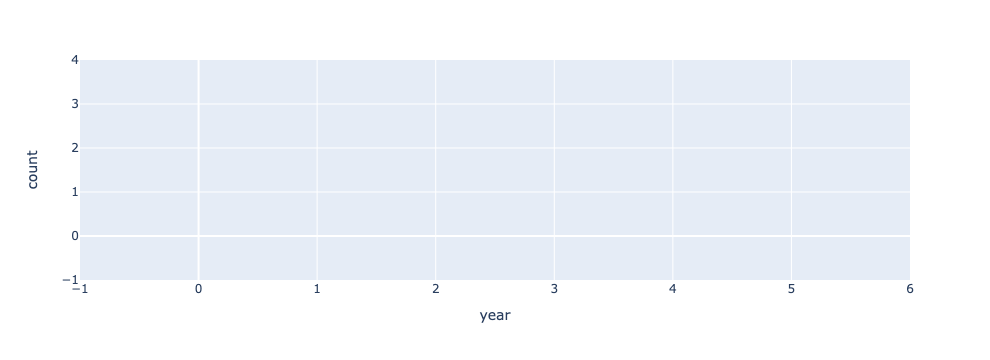

In [12]:
df = pd.DataFrame(year_categories)
cats = []
for col in df.columns:
    top_cats = [i for i in df[col].fillna(0).sort_values().index][-10:]
    cats.extend(top_cats)
cats = list(set(cats))

df1 = df.T[cats]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['index'])
df2.columns = ['year', 'category', 'count']
fig = px.line(df2, x="year", y="count", color='category')
fig.show()

In [8]:
for c in sorted(cats):
    if c in category_map:
        print(f"{c}: {category_map[c]}")

astro-ph: Astrophysics
astro-ph.CO: Cosmology and Nongalactic Astrophysics
astro-ph.EP: Earth and Planetary Astrophysics
astro-ph.GA: Astrophysics of Galaxies
astro-ph.HE: High Energy Astrophysical Phenomena
astro-ph.IM: Instrumentation and Methods for Astrophysics
astro-ph.SR: Solar and Stellar Astrophysics
cond-mat.dis-nn: Disordered Systems and Neural Networks
cond-mat.mes-hall: Mesoscale and Nanoscale Physics
cond-mat.mtrl-sci: Materials Science
cond-mat.quant-gas: Quantum Gases
cond-mat.soft: Soft Condensed Matter
cond-mat.stat-mech: Statistical Mechanics
cond-mat.str-el: Strongly Correlated Electrons
cond-mat.supr-con: Superconductivity
cs.AI: Artificial Intelligence
cs.CC: Computational Complexity
cs.CL: Computation and Language
cs.CV: Computer Vision and Pattern Recognition
cs.DS: Data Structures and Algorithms
cs.GR: Graphics
cs.IR: Information Retrieval
cs.IT: Information Theory
cs.LG: Machine Learning
cs.LO: Logic in Computer Science
cs.MM: Multimedia
cs.NI: Networking and I

There are so many different and interesting trends!
* for example, there are some fluctuations due to terminology - at first there were a lot of papers in `astro-ph` category, but later it was split in multiple categories
* there was a surge in papers on astrophysics since 2010, but since 2014 `Cosmology and Nongalactic Astrophysics` became less popular than `Astrophysics of Galaxies`
* of course, in the last several years there are many papers about `Machine Learning`

## Number of papers by authors over years

In [9]:
df = pd.DataFrame(year_authors)
authors = []
for col in df.columns:
    top_authors = [i for i in df[col].fillna(0).sort_values().index][-10:]
    authors.extend(top_authors)
authors = list(set(authors))

df1 = df.T[authors]
df1 = df1.sort_index()
df2 = df1.reset_index().melt(id_vars=['index'])
df2.columns = ['year', 'author', 'count']
fig = px.line(df2, x="year", y="count", color='author', width=1600, height=600)
fig.show()

We can see some prominent authors from many fields on study!